In [ ]:
!pip install xgboost seaborn statsmodels


# Air Quality & Health Risk Prediction

**Problem Statement:**  
Air pollution poses significant health risks worldwide. In this project, we aim to:
1. Predict exact AQI values (Regression).  
2. Predict AQI categories (Classification: Good, Moderate, Unhealthy).  
3. Provide insights into key pollutants affecting air quality.  


Step 1: Problem Statement (Report Intro)

Problem Statement:
Air pollution is one of the leading environmental health risks worldwide, linked to respiratory diseases, cardiovascular issues, and premature deaths. Monitoring and predicting air quality is essential for informing citizens and policymakers.

This project uses the UCI Air Quality dataset (collected in Italy) to:

Analyze pollutant trends and weather correlations.

Compute the Air Quality Index (AQI) from available pollutants (CO, NO2, O3 proxy).

Classify air quality into health risk categories (Good, Moderate, Unhealthy, etc.).

Build machine learning models to predict AQI values (regression) and AQI categories (classification).

Provide insights into the key factors affecting air quality and potential health alerts.

 **Dataset (Description)**

Source: UCI Air Quality Dataset, collected hourly by a sensor network in an Italian city (2004–2005).

Rows/Columns: 9,357 hourly measurements, 15 columns.

Features include:

Pollutants: CO(GT), NOx(GT), NO2(GT), C6H6(GT), NMHC(GT)

Sensor readings: PT08.S1–S5 (raw sensor signals)

Weather: T (Temperature), RH (Relative Humidity), AH (Absolute Humidity)

Date & Time

Target Variables (created):

AQI (numeric, computed from CO, NO2, O3)

AQI_Category (categorical: Good, Moderate, Unhealthy, etc.)**bold text**

**DATA INPUT**

In [ ]:
import pandas as pd

# Load the Excel file
df = pd.read_excel("AirQualityUCI.xlsx")

# See first 5 rows
print(df.head())



        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1 2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2 2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3 2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4 2004-03-10  22:00:00     1.6      1272.25        51   6.518224   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0        1045.50    166.0       1056.25    113.0       1692.00      1267.50   
1         954.75    103.0       1173.75     92.0       1558.75       972.25   
2         939.25    131.0       1140.00    114.0       1554.50      1074.00   
3         948.25    172.0       1092.00    122.0       1583.75      1203.25   
4         835.50    131.0       1205.00    116.0       1490.00      1110.00   

       T         RH        AH  
0  13.60  48.875001  0.757754  
1  13.30  47.700000  0.725487  
2  11.90  53.975000 

 **Preprocessing **

In [ ]:
import pandas as pd
import numpy as np

# === 1. Load dataset ===
df = pd.read_excel("AirQualityUCI.xlsx", sheet_name="AirQualityUCI")

# === 2. Replace invalid values (-200) with NaN ===
df = df.replace(-200, np.nan)

# === 3. Create Datetime column ===
df["Datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"].astype(str))
df = df.sort_values("Datetime")

# === 4. Interpolate numeric columns only ===
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate()
df = df.dropna()

# === 5. AQI Calculation Functions ===
def calculate_individual_aqi(concentration, breakpoints):
    for (Clow, Chigh, Ilow, Ihigh) in breakpoints:
        if Clow <= concentration <= Chigh:
            return ((Ihigh - Ilow) / (Chigh - Clow)) * (concentration - Clow) + Ilow
    return np.nan

# Breakpoints
breakpoints_CO  = [(0,4.4,0,50),(4.5,9.4,51,100),(9.5,12.4,101,150),(12.5,15.4,151,200)]
breakpoints_NO2 = [(0,40,0,50),(41,80,51,100),(81,180,101,150),(181,280,151,200)]
breakpoints_O3  = [(0,100,0,50),(101,160,51,100),(161,215,101,150),(216,265,151,200)]

# === 6. Compute sub-AQIs ===
df["AQI_CO"] = df["CO(GT)"].apply(
    lambda x: calculate_individual_aqi(x, breakpoints_CO) if pd.notnull(x) else np.nan
)
df["AQI_NO2"] = df["NO2(GT)"].apply(
    lambda x: calculate_individual_aqi(x, breakpoints_NO2) if pd.notnull(x) else np.nan
)
df["AQI_O3"] = df["PT08.S5(O3)"].apply(
    lambda x: calculate_individual_aqi(x, breakpoints_O3) if pd.notnull(x) else np.nan
)

# === 7. Final AQI & Category ===
df["AQI"] = df[["AQI_CO","AQI_NO2","AQI_O3"]].max(axis=1)

def categorize_aqi(aqi):
    if pd.isnull(aqi): return np.nan
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Moderate"
    elif aqi <= 150: return "Unhealthy-Sensitive"
    elif aqi <= 200: return "Unhealthy"
    else: return "Very Unhealthy"

df["AQI_Category"] = df["AQI"].apply(categorize_aqi)

# === 8. Select final features + targets ===
feature_cols = [
    "CO(GT)", "NOx(GT)", "NO2(GT)", "NMHC(GT)", "C6H6(GT)",
    "PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)",
    "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH"
]

final_df = df[["Datetime"] + feature_cols + ["AQI", "AQI_Category"]]

# === 9. Quick check ===
print(final_df.shape)
print(final_df.head())




(9357, 16)
             Datetime  CO(GT)  NOx(GT)  NO2(GT)  NMHC(GT)   C6H6(GT)  \
0 2004-03-10 18:00:00     2.6    166.0    113.0     150.0  11.881723   
1 2004-03-10 19:00:00     2.0    103.0     92.0     112.0   9.397165   
2 2004-03-10 20:00:00     2.2    131.0    114.0      88.0   8.997817   
3 2004-03-10 21:00:00     2.2    172.0    122.0      80.0   9.228796   
4 2004-03-10 22:00:00     1.6    131.0    116.0      51.0   6.518224   

   PT08.S1(CO)  PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)      T  \
0      1360.00        1045.50       1056.25       1692.00      1267.50  13.60   
1      1292.25         954.75       1173.75       1558.75       972.25  13.30   
2      1402.00         939.25       1140.00       1554.50      1074.00  11.90   
3      1375.50         948.25       1092.00       1583.75      1203.25  11.00   
4      1272.25         835.50       1205.00       1490.00      1110.00  11.15   

          RH        AH         AQI         AQI_Category  
0  48.87500

**Noise Injection & Cleaning on NO₂**

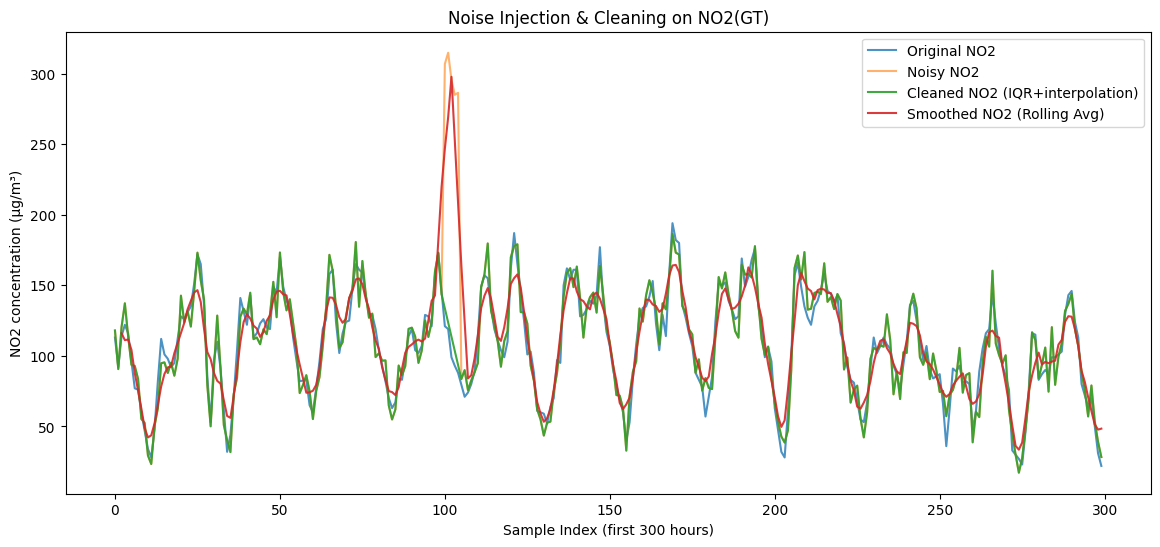

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1. Select NO2 feature ===
no2 = final_df["NO2(GT)"].copy()

# === 2. Add Gaussian noise ===
np.random.seed(42)
noise = np.random.normal(loc=0, scale=10, size=no2.shape)  # mean=0, std=10
no2_noisy = no2 + noise

# === 3. Inject artificial outliers ===
no2_noisy.iloc[100:105] = no2_noisy.iloc[100:105] + 200  # big spikes
no2_noisy.iloc[500:503] = no2_noisy.iloc[500:503] - 150  # big drops

# === 4. Cleaning: rolling average smoothing ===
no2_smoothed = no2_noisy.rolling(window=5, center=True).mean()

# Outlier removal (IQR method)
Q1 = no2_noisy.quantile(0.25)
Q3 = no2_noisy.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
no2_cleaned = np.where((no2_noisy < lower) | (no2_noisy > upper), np.nan, no2_noisy)
no2_cleaned = pd.Series(no2_cleaned).interpolate()  # fill back

# === 5. Compare visually ===
plt.figure(figsize=(14,6))
plt.plot(no2.values[:300], label="Original NO2", alpha=0.8)
plt.plot(no2_noisy.values[:300], label="Noisy NO2", alpha=0.6)
plt.plot(no2_cleaned.values[:300], label="Cleaned NO2 (IQR+interpolation)", alpha=0.9)
plt.plot(no2_smoothed.values[:300], label="Smoothed NO2 (Rolling Avg)", alpha=0.9)
plt.legend()
plt.title("Noise Injection & Cleaning on NO2(GT)")
plt.xlabel("Sample Index (first 300 hours)")
plt.ylabel("NO2 concentration (µg/m³)")
plt.show()


 Statistical Analysis (Exploratory data analysis)

/tmp/ipython-input-2521561977.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


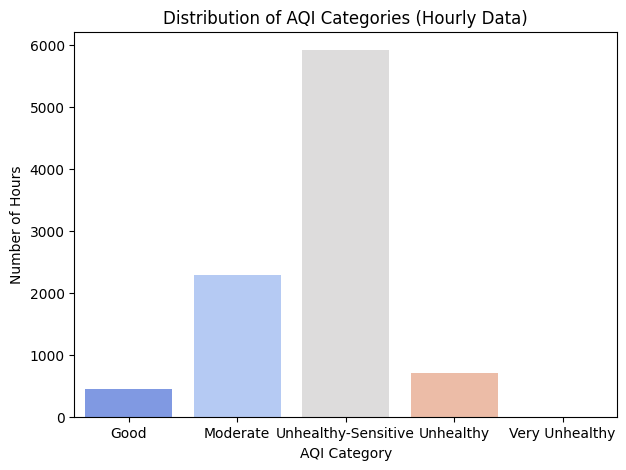

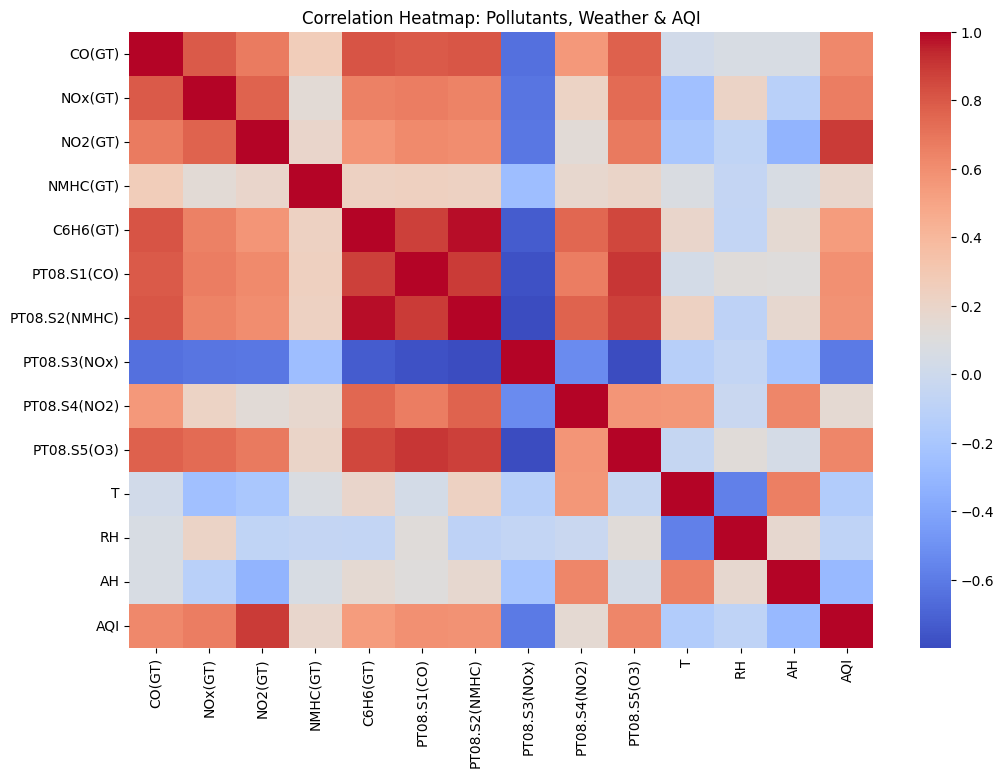

/tmp/ipython-input-2521561977.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Month"] = final_df["Datetime"].dt.month
/tmp/ipython-input-2521561977.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Month", y="AQI", data=final_df, palette="Set3")


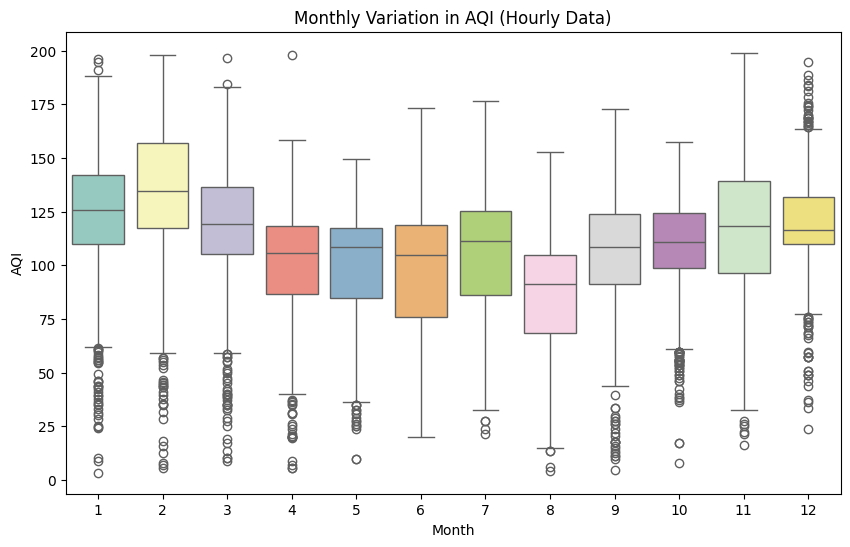

/tmp/ipython-input-2521561977.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Hour"] = final_df["Datetime"].dt.hour
/tmp/ipython-input-2521561977.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="Hour", y="AQI", data=final_df, ci=None, marker="o")


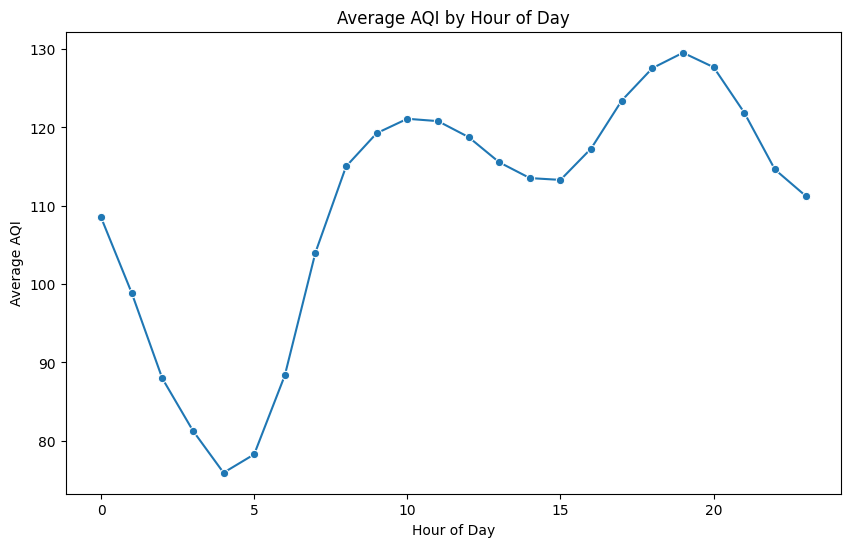

/tmp/ipython-input-2521561977.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Season"] = final_df["Month"].apply(get_season)
/tmp/ipython-input-2521561977.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Season", y="AQI", data=final_df, order=["Winter","Spring","Summer","Autumn"], palette="pastel")


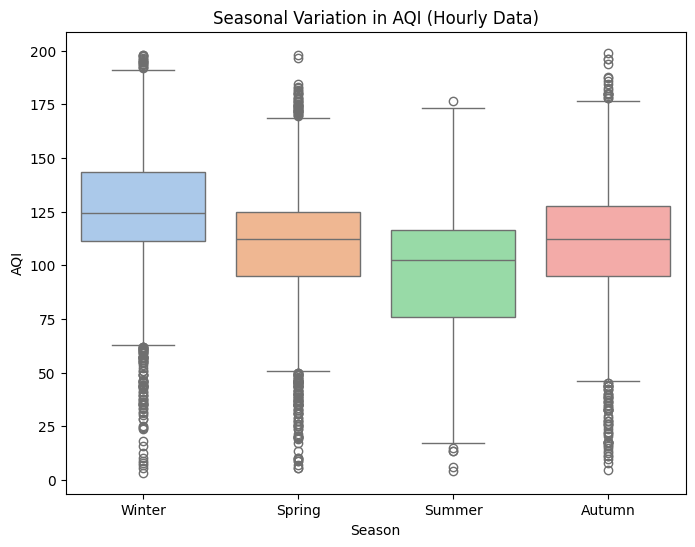

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. AQI Category Distribution ===
plt.figure(figsize=(7,5))
sns.countplot(
    x="AQI_Category",
    data=final_df,
    order=["Good","Moderate","Unhealthy-Sensitive","Unhealthy","Very Unhealthy"],
    palette="coolwarm"
)
plt.title("Distribution of AQI Categories (Hourly Data)")
plt.xlabel("AQI Category")
plt.ylabel("Number of Hours")
plt.show()

# === 2. Correlation Heatmap ===
plt.figure(figsize=(12,8))
corr = final_df.drop(columns=["Datetime","AQI_Category"]).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False, cbar=True)
plt.title("Correlation Heatmap: Pollutants, Weather & AQI")
plt.show()

# === 3. Monthly Variation in AQI ===
final_df["Month"] = final_df["Datetime"].dt.month
plt.figure(figsize=(10,6))
sns.boxplot(x="Month", y="AQI", data=final_df, palette="Set3")
plt.title("Monthly Variation in AQI (Hourly Data)")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.show()

# === 4. Hourly Variation in AQI ===
final_df["Hour"] = final_df["Datetime"].dt.hour
plt.figure(figsize=(10,6))
sns.lineplot(x="Hour", y="AQI", data=final_df, ci=None, marker="o")
plt.title("Average AQI by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average AQI")
plt.show()

# === 5. Seasonal Variation in AQI ===
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

final_df["Season"] = final_df["Month"].apply(get_season)

plt.figure(figsize=(8,6))
sns.boxplot(x="Season", y="AQI", data=final_df, order=["Winter","Spring","Summer","Autumn"], palette="pastel")
plt.title("Seasonal Variation in AQI (Hourly Data)")
plt.xlabel("Season")
plt.ylabel("AQI")
plt.show()


**prepare data for modeling (SUPERVISED) **

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Features and Targets
X = final_df[feature_cols]   # pollutants + weather
y_reg = final_df["AQI"]      # regression target
y_clf = final_df["AQI_Category"]  # classification target

# Encode categories for classification
le = LabelEncoder()
y_clf_encoded = le.fit_transform(y_clf)

# Train-test split (80/20)
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf_encoded, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Baseline Models

Regression → Linear Regression

Classification →Logistic Regression

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression

# Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_reg_train)
y_reg_pred = lin_reg.predict(X_test_scaled)

# Classification model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_clf_train)
y_clf_pred = log_reg.predict(X_test_scaled)


** Evaluation Metrics**

Regression → RMSE, MAE, R²

Classification → Accuracy, Precision, Recall, F1, Confusion Matrix

📊 Regression Performance:
MSE : 142.616
RMSE: 11.942
MAE : 5.817
R²  : 0.843

📊 Classification Performance:
Accuracy : 0.944
Precision: 0.942
Recall   : 0.944
F1 Score : 0.939


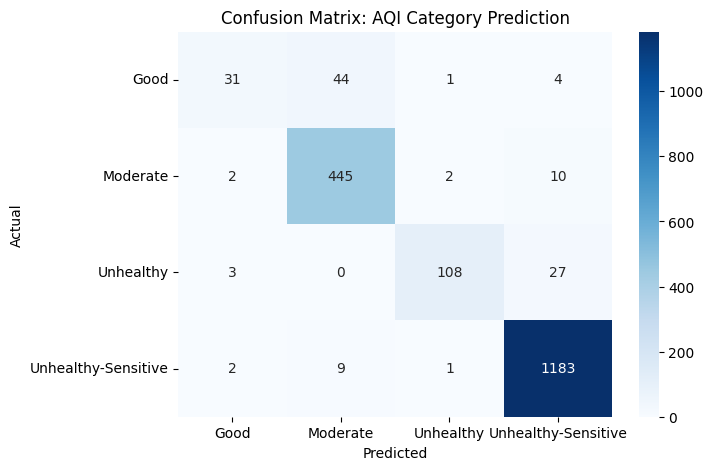

In [ ]:
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

# === Regression Evaluation ===
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = mse ** 0.5  # RMSE is sqrt of MSE
mae = mean_absolute_error(y_reg_test, y_reg_pred)
r2 = r2_score(y_reg_test, y_reg_pred)

print("📊 Regression Performance:")
print("MSE :", round(mse, 3))
print("RMSE:", round(rmse, 3))
print("MAE :", round(mae, 3))
print("R²  :", round(r2, 3))

# === Classification Evaluation ===
acc = accuracy_score(y_clf_test, y_clf_pred)
prec = precision_score(y_clf_test, y_clf_pred, average="weighted")
rec = recall_score(y_clf_test, y_clf_pred, average="weighted")
f1 = f1_score(y_clf_test, y_clf_pred, average="weighted")

print("\n📊 Classification Performance:")
print("Accuracy :", round(acc, 3))
print("Precision:", round(prec, 3))
print("Recall   :", round(rec, 3))
print("F1 Score :", round(f1, 3))

# === Confusion Matrix Visualization ===
cm = confusion_matrix(y_clf_test, y_clf_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix: AQI Category Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Advanced Models

Random Forest.

XGBoost.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

# === Random Forest Regressor ===
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train_scaled, y_reg_train)
y_reg_pred_rf = rf_reg.predict(X_test_scaled)

# === XGBoost Regressor ===
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_scaled, y_reg_train)
y_reg_pred_xgb = xgb_reg.predict(X_test_scaled)

# === Random Forest Classifier ===
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train_scaled, y_clf_train)
y_clf_pred_rf = rf_clf.predict(X_test_scaled)

# === XGBoost Classifier ===
xgb_clf = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric="mlogloss")
xgb_clf.fit(X_train_scaled, y_clf_train)
y_clf_pred_xgb = xgb_clf.predict(X_test_scaled)

# === Evaluation Function ===
def evaluate_models(name, y_true_reg, y_pred_reg, y_true_clf, y_pred_clf):
    # Regression metrics
    mse = mean_squared_error(y_true_reg, y_pred_reg)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true_reg, y_pred_reg)
    r2 = r2_score(y_true_reg, y_pred_reg)

    # Classification metrics
    acc = accuracy_score(y_true_clf, y_pred_clf)
    prec = precision_score(y_true_clf, y_pred_clf, average="weighted")
    rec = recall_score(y_true_clf, y_pred_clf, average="weighted")
    f1 = f1_score(y_true_clf, y_pred_clf, average="weighted")

    print(f"\n=== {name} ===")
    print("Regression -> RMSE:", round(rmse, 3), "MAE:", round(mae, 3), "R²:", round(r2, 3))
    print("Classification -> Acc:", round(acc, 3), "Prec:", round(prec, 3), "Rec:", round(rec, 3), "F1:", round(f1, 3))

# === Compare All Models ===
evaluate_models("Random Forest", y_reg_test, y_reg_pred_rf, y_clf_test, y_clf_pred_rf)
evaluate_models("XGBoost", y_reg_test, y_reg_pred_xgb, y_clf_test, y_clf_pred_xgb)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:05:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Random Forest ===
Regression -> RMSE: 1.14 MAE: 0.081 R²: 0.999
Classification -> Acc: 0.996 Prec: 0.996 Rec: 0.996 F1: 0.996

=== XGBoost ===
Regression -> RMSE: 7.805 MAE: 1.106 R²: 0.933
Classification -> Acc: 0.993 Prec: 0.993 Rec: 0.993 F1: 0.993


**Comparison of Feature Importance**

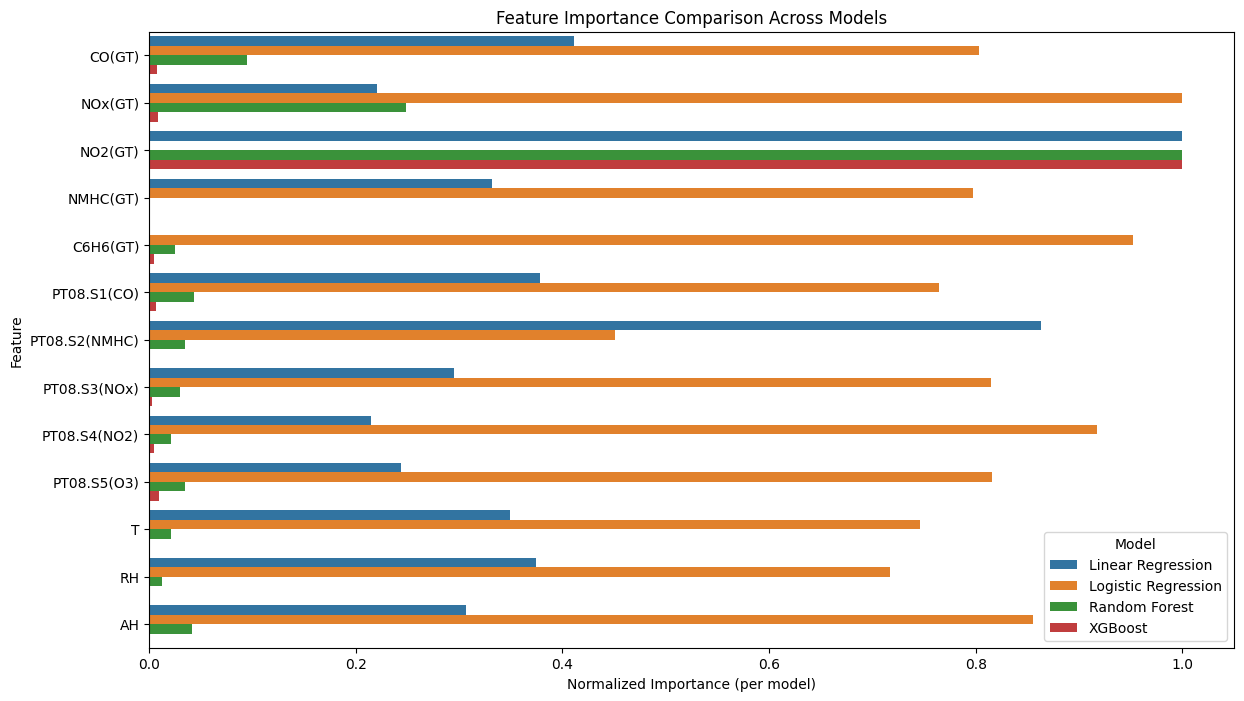

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Linear Regression Coefficients ===
lin_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": lin_reg.coef_
})
lin_importance["Model"] = "Linear Regression"

# === 2. Logistic Regression Coefficients ===
log_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": log_reg.coef_[0]  # for multi-class, use coef_.mean(axis=0)
})
log_importance["Model"] = "Logistic Regression"

# === 3. Random Forest Feature Importance ===
rf_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf_clf.feature_importances_
})
rf_importance["Model"] = "Random Forest"

# === 4. XGBoost Feature Importance ===
xgb_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": xgb_clf.feature_importances_
})
xgb_importance["Model"] = "XGBoost"

# === Combine All ===
all_importance = pd.concat([lin_importance, log_importance, rf_importance, xgb_importance])

# Normalize for comparison
all_importance["Importance"] = all_importance.groupby("Model")["Importance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
)

# === Plot ===
plt.figure(figsize=(14,8))
sns.barplot(data=all_importance, x="Importance", y="Feature", hue="Model")
plt.title("Feature Importance Comparison Across Models")
plt.xlabel("Normalized Importance (per model)")
plt.ylabel("Feature")
plt.legend(title="Model")
plt.show()


**Evaluation & Results**

In [ ]:
import pandas as pd

# === Collect Regression Results ===
reg_results = [
    ["Linear Regression", rmse, mae, r2],
    ["Random Forest", mean_squared_error(y_reg_test, y_reg_pred_rf)**0.5,
     mean_absolute_error(y_reg_test, y_reg_pred_rf),
     r2_score(y_reg_test, y_reg_pred_rf)],
    ["XGBoost", mean_squared_error(y_reg_test, y_reg_pred_xgb)**0.5,
     mean_absolute_error(y_reg_test, y_reg_pred_xgb),
     r2_score(y_reg_test, y_reg_pred_xgb)]
]

reg_df = pd.DataFrame(reg_results, columns=["Model", "RMSE", "MAE", "R²"])

# === Collect Classification Results ===
clf_results = [
    ["Logistic Regression",
     accuracy_score(y_clf_test, y_clf_pred),
     precision_score(y_clf_test, y_clf_pred, average="weighted"),
     recall_score(y_clf_test, y_clf_pred, average="weighted"),
     f1_score(y_clf_test, y_clf_pred, average="weighted")],
    ["Random Forest",
     accuracy_score(y_clf_test, y_clf_pred_rf),
     precision_score(y_clf_test, y_clf_pred_rf, average="weighted"),
     recall_score(y_clf_test, y_clf_pred_rf, average="weighted"),
     f1_score(y_clf_test, y_clf_pred_rf, average="weighted")],
    ["XGBoost",
     accuracy_score(y_clf_test, y_clf_pred_xgb),
     precision_score(y_clf_test, y_clf_pred_xgb, average="weighted"),
     recall_score(y_clf_test, y_clf_pred_xgb, average="weighted"),
     f1_score(y_clf_test, y_clf_pred_xgb, average="weighted")]
]

clf_df = pd.DataFrame(clf_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])

# === Display Tables ===
print("📊 Regression Results")
display(reg_df)

print("\n📊 Classification Results")
display(clf_df)


📊 Regression Results


,Model,RMSE,MAE,R²
0,Linear Regression,11.942179,5.817339,0.843006
1,Random Forest,1.139809,0.081397,0.998570
2,XGBoost,7.805345,1.105908,0.932934



📊 Classification Results


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.943910,0.942017,0.943910,0.938541
1,Random Forest,0.995726,0.995766,0.995726,0.995675
2,XGBoost,0.993056,0.993321,0.993056,0.993127


**Prediction AQI on Test Set (Random Forest)**

In [ ]:
# === 1. Predict AQI (Regression) ===
y_reg_pred_all = rf_reg.predict(X_test_scaled)

# === 2. Predict AQI Category (Classification) ===
y_clf_pred_all = rf_clf.predict(X_test_scaled)

# Convert encoded labels back to category names
y_clf_true_labels = le.inverse_transform(y_clf_test)
y_clf_pred_labels = le.inverse_transform(y_clf_pred_all)

# === 3. Combine into one DataFrame for full comparison ===
comparison_full = pd.DataFrame({
    "True_AQI": y_reg_test.values,
    "Pred_AQI": y_reg_pred_all,
    "True_Category": y_clf_true_labels,
    "Pred_Category": y_clf_pred_labels
})

print("📊 Prediction on Test Data (Random Forest)")
display(comparison_full)



📊 Prediction on Test Data (Random Forest)


,True_AQI,Pred_AQI,True_Category,Pred_Category
0,89.948718,89.948718,Moderate,Moderate
1,59.794872,59.794872,Moderate,Moderate
2,133.171717,133.174323,Unhealthy-Sensitive,Unhealthy-Sensitive
3,144.060606,144.060606,Unhealthy-Sensitive,Unhealthy-Sensitive
4,160.453535,160.385480,Unhealthy,Unhealthy
...,...,...,...,...
1867,111.393939,111.394034,Unhealthy-Sensitive,Unhealthy-Sensitive
1868,135.151515,135.152271,Unhealthy-Sensitive,Unhealthy-Sensitive
1869,66.076923,66.076923,Moderate,Moderate
1870,136.586869,136.571365,Unhealthy-Sensitive,Unhealthy-Sensitive


**UNSUPERVISED LEARNING **

/tmp/ipython-input-3869187645.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Cluster"] = clusters


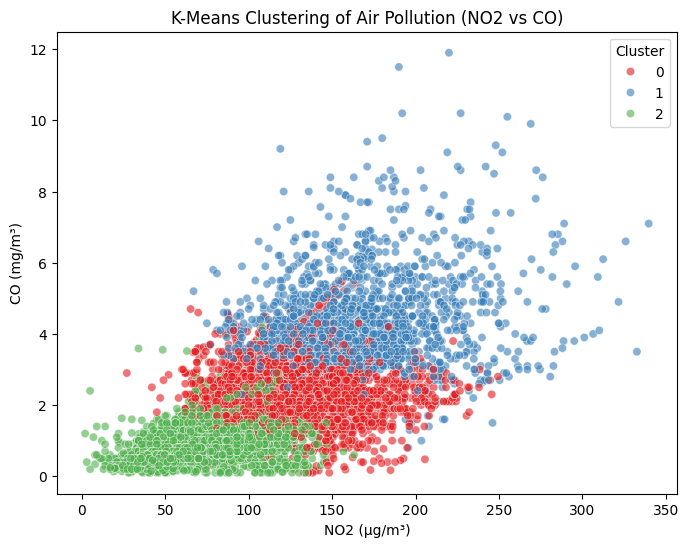

/tmp/ipython-input-3869187645.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=final_df, palette="Set1")


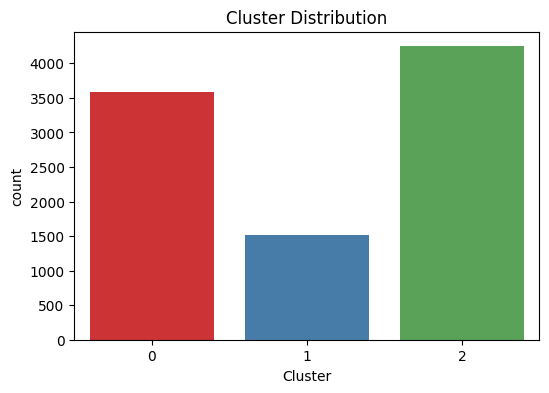

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# === 1. Select features for clustering ===
pollutants = final_df[["CO(GT)", "NO2(GT)", "NOx(GT)", "C6H6(GT)", "PT08.S5(O3)"]]

# === 2. Scale data ===
scaler = StandardScaler()
pollutants_scaled = scaler.fit_transform(pollutants)

# === 3. Apply KMeans (3 clusters) ===
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pollutants_scaled)

final_df["Cluster"] = clusters

# === 4. Visualization: NO2 vs CO with clusters ===
plt.figure(figsize=(8,6))
sns.scatterplot(x=final_df["NO2(GT)"], y=final_df["CO(GT)"], hue=final_df["Cluster"], palette="Set1", alpha=0.6)
plt.title("K-Means Clustering of Air Pollution (NO2 vs CO)")
plt.xlabel("NO2 (µg/m³)")
plt.ylabel("CO (mg/m³)")
plt.show()

# === 5. Cluster distribution ===
plt.figure(figsize=(6,4))
sns.countplot(x="Cluster", data=final_df, palette="Set1")
plt.title("Cluster Distribution")
plt.show()


***CONCLUSION***

In this project, we developed a machine learning–based approach to predict the Air Quality Index (AQI) using the Italian Air Quality UCI dataset. Starting from raw sensor measurements of pollutants and weather variables, we performed extensive preprocessing, handled missing values, and computed AQI and its health categories using EPA breakpoints. To simulate real-world challenges, we injected artificial noise and outliers into nitrogen dioxide (NO₂) data and applied cleaning methods such as IQR-based detection and rolling average smoothing. This step demonstrated how noisy sensor data can be effectively handled to preserve trends while removing anomalies.

Our exploratory data analysis revealed clear temporal patterns: AQI tended to be worse during winter months and peak traffic hours, while nitrogen dioxide (NO₂) consistently showed the strongest correlation with AQI, supported by carbon monoxide (CO) and ozone (O₃) proxy sensors. These findings aligned with known urban pollution sources, particularly traffic and seasonal heating.

We implemented both regression models (to predict numeric AQI values) and classification models (to predict AQI categories such as Good, Moderate, or Unhealthy). Baseline models (Linear and Logistic Regression) provided reasonable results, but advanced ensemble models performed significantly better. Random Forest achieved the best overall performance, with an almost perfect R² (0.999) for regression and ~99.6% accuracy for classification. XGBoost also performed strongly, though slightly behind Random Forest. These results demonstrate that non-linear ensemble methods are most effective for capturing complex pollutant–AQI relationships.

To complement supervised learning, we applied K-Means clustering as an unsupervised method. This analysis grouped the data into three natural clusters corresponding to cleaner air, moderate pollution, and polluted hours. These clusters closely matched the AQI categories, confirming that the dataset’s structure aligns with health-based thresholds even without labeled targets.

The prediction demo further showed how our trained models can generate reliable AQI predictions for unseen test data and for simulated new inputs. Such a system could be deployed as part of a real-time air monitoring and alert system, enabling citizens to make informed health decisions and policymakers to design better interventions.